## Remap from pressure/depth to isopycnals

It is useful to analyze the data on isopycnals for two reasons:
- Remove influence of internal waves
- Tracers are stirred primarily along isopycnals in the interior

Here we will do this remapping using linear interpolation, and start from the data that has already been QCed, overturns removed, and vertically binned.  

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.signal as sg
import spectrum 
from scipy import stats, fft
import xarray as xr
from cmocean import cm as cmo


In [3]:
import hvplot.xarray

In [4]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [5]:
ds_660_grid = xr.open_dataset('data/ctd_660_vert_binned_29_june_2021.nc')
# Calculate a time axis as YTD
days = ds_660_grid.time - np.datetime64('2019-01-01')
days_round_660 = (days / np.timedelta64(1, 'D')).round()
ds_660_grid['days'] = (days / np.timedelta64(1, 'D'))

In [6]:
ds_660_grid

<xarray.Dataset>
Dimensions:       (ctd_pressure: 100, dives: 1007)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 5.0 15.0 25.0 ... 975.0 985.0 995.0
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    sigma0        (ctd_pressure, dives) float64 ...
    SA            (ctd_pressure, dives) float64 ...
    CT            (ctd_pressure, dives) float64 ...
    time          (ctd_pressure, dives) datetime64[ns] 2019-04-30T12:15:30.70...
    latitude      (ctd_pressure, dives) float64 ...
    longitude     (ctd_pressure, dives) float64 ...
    days          (ctd_pressure, dives) float64 119.5 119.5 119.5 ... nan nan
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-06-29 12:36:06] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

In [9]:
ds_660_grid.sigma0.sel(dives=100).hvplot()

:Curve   [ctd_pressure]   (sigma0)

#### Choosing density grid
We need to choose a density grid that results in very little loss of information, which means that having a variable $d\rho$ might be helpful. The steps can be finer in the mixed layer and deep ocean and less fine in the interior. 

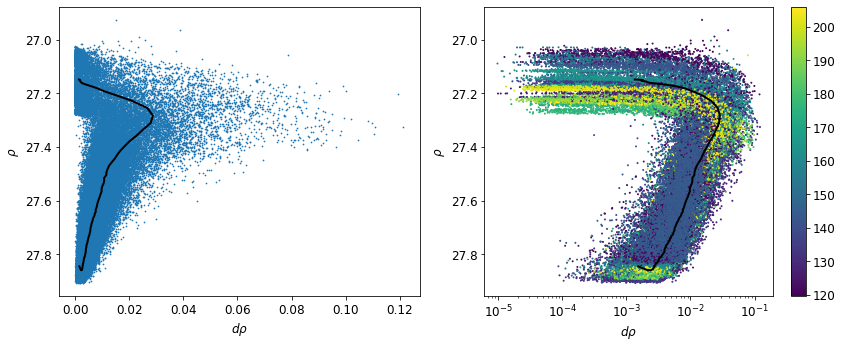

In [39]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(ds_660_grid.sigma0.diff('ctd_pressure'), ds_660_grid.sigma0[1:,:],
           s=0.5)
plt.plot(ds_660_grid.sigma0.diff('ctd_pressure').mean('dives'), 
         ds_660_grid.sigma0[1:,:].mean('dives'), color='k', linewidth=2)
plt.gca().invert_yaxis()
plt.xlabel(r'$d \rho$')
plt.ylabel(r'$\rho$')
#plt.xscale('log')

plt.subplot(122)
plt.scatter(ds_660_grid.sigma0.diff('ctd_pressure'), ds_660_grid.sigma0[1:,:],
           s=1, c=ds_660_grid.days[1:,:])
plt.plot(ds_660_grid.sigma0.diff('ctd_pressure').mean('dives'), 
         ds_660_grid.sigma0[1:,:].mean('dives'), color='k', linewidth=2)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel(r'$d \rho$')
plt.ylabel(r'$\rho$')

plt.tight_layout()

In [68]:
rho_grid = np.linspace(27.0, 27.9,901)

In [42]:
from scipy import interpolate

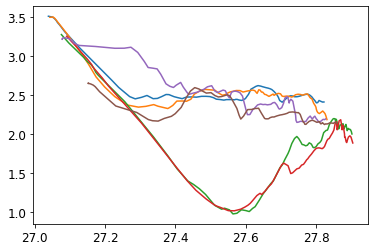

In [49]:
sel_dives = [20, 30, 100,105, 205, 300]
plt.plot(ds_660_grid.sigma0.sel(dives=sel_dives), ds_660_grid.CT.sel(dives=sel_dives))

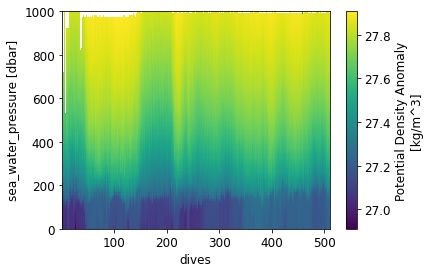

In [53]:
ds_660_grid.sigma0.plot()

#### Pressure to density grid
The interpolation requires us to invert functions like 
\begin{equation}
\rho = f(p)
\end{equation}
to 
\begin{equation}
p = g(\rho)
\end{equation}

and also
$$
T = f(p)
$$
to
$$
T = f(g(\rho))
$$

This can be done using interpolation, where we 
- take the variables as a function of pressure and the associated non-uniformly spaced density.
- Find the interpolant function that relates the variable to the non-uniformly spaced density.
- Use this interpolant function to estimate the values at a set of uniformly spaced density points. 

In [93]:
# Try on a single dive
dive_num = 100

rho = ds_660_grid.sigma0.sel(dives=dive_num)
rho_nonan = rho.where(~np.isnan(rho), drop=True)
pres_nonan = ds_660_grid.ctd_pressure.where(~np.isnan(rho), drop=True)
CT_nonan = ds_660_grid.CT.sel(dives=dive_num).where(~np.isnan(rho), drop=True)
SA_nonan = ds_660_grid.SA.sel(dives=dive_num).where(~np.isnan(rho), drop=True)

# Here we find the function p = f(\rho)
frho = interpolate.PchipInterpolator(rho_nonan, pres_nonan, extrapolate=False)#, bounds_error=False )
pres_tilde = frho(rho_grid)

# CT = f(\rho)
fCT = interpolate.PchipInterpolator(rho_nonan, CT_nonan, extrapolate=False)#, bounds_error=False )
CT_tilde = fCT(rho_grid)

# SA = f(\rho)
fSA = interpolate.PchipInterpolator(rho_nonan, SA_nonan, extrapolate=False)#, bounds_error=False )
SA_tilde = fSA(rho_grid)

(600.0, 900.0)

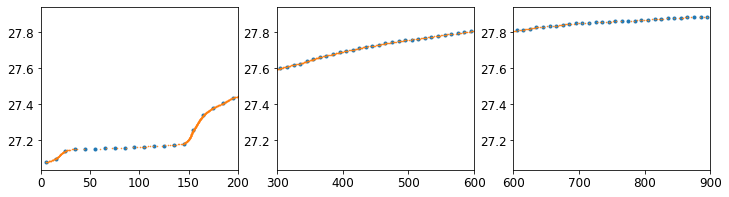

In [95]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.plot(pres_nonan, rho_nonan, '.')
plt.plot(pres_tilde, rho_grid, '.', markersize=1)
plt.xlim([0,200])

plt.subplot(132)
plt.plot(pres_nonan, rho_nonan, '.')
plt.plot(pres_tilde, rho_grid, '.', markersize=1)
plt.xlim([300,600])

plt.subplot(133)
plt.plot(pres_nonan, rho_nonan, '.')
plt.plot(pres_tilde, rho_grid, '.', markersize=1)
plt.xlim([600,900])


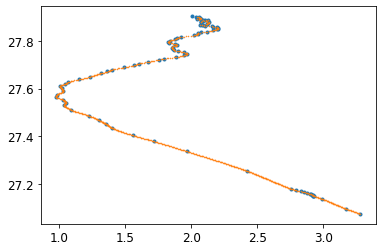

In [96]:
plt.plot(CT_nonan, rho_nonan, '.')
plt.plot(CT_tilde, rho_grid, '.', markersize=1)

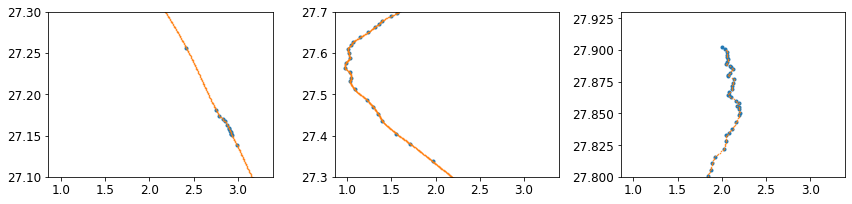

In [101]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.plot(CT_nonan, rho_nonan, '.')
plt.plot(CT_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.1,27.3])

plt.subplot(132)
plt.plot(CT_nonan, rho_nonan, '.')
plt.plot(CT_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.3,27.7])

plt.subplot(133)
plt.plot(CT_nonan, rho_nonan, '.')
plt.plot(CT_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.80,27.93])

plt.tight_layout()

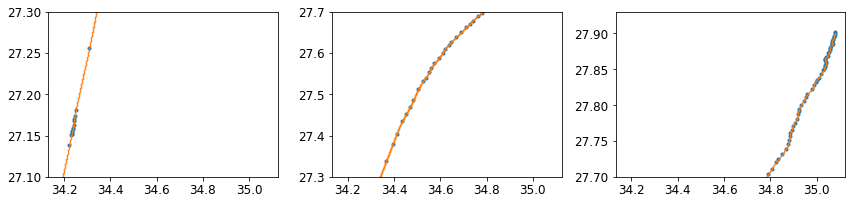

In [100]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.plot(SA_nonan, rho_nonan, '.')
plt.plot(SA_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.1,27.3])

plt.subplot(132)
plt.plot(SA_nonan, rho_nonan, '.')
plt.plot(SA_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.3,27.7])

plt.subplot(133)
plt.plot(SA_nonan, rho_nonan, '.')
plt.plot(SA_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.7,27.93])

plt.tight_layout()

In [102]:
ds_660_grid

<xarray.Dataset>
Dimensions:       (ctd_pressure: 100, dives: 1007)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 5.0 15.0 25.0 ... 975.0 985.0 995.0
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    sigma0        (ctd_pressure, dives) float64 ...
    SA            (ctd_pressure, dives) float64 ...
    CT            (ctd_pressure, dives) float64 ...
    time          (ctd_pressure, dives) datetime64[ns] 2019-04-30T12:15:30.70...
    latitude      (ctd_pressure, dives) float64 ...
    longitude     (ctd_pressure, dives) float64 ...
    days          (ctd_pressure, dives) float64 119.5 119.5 119.5 ... nan nan
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-06-29 12:36:06] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

In [110]:
pres_tilde.reshape((-1,1)).shape

(901, 1)

In [111]:
pres_tilde_xr = xr.DataArray( pres_tilde.reshape((-1,1)), 
            dims=['rho_grid', 'dives'],
            coords={'rho_grid':rho_grid, 'dives': [1.] })

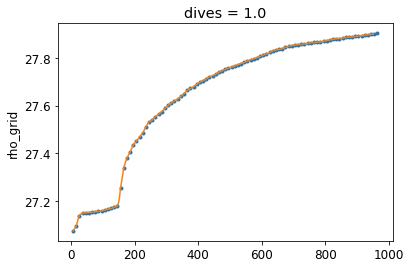

In [117]:
plt.plot(pres_nonan, rho_nonan, '.')
pres_tilde_xr.plot(y='rho_grid')

In [121]:
xr.concat([pres_tilde_xr, pres_tilde_xr], dim='dives')

<xarray.DataArray (rho_grid: 901, dives: 2)>
array([[         nan,          nan],
       [         nan,          nan],
       [         nan,          nan],
       ...,
       [944.8890776 , 944.8890776 ],
       [948.91663235, 948.91663235],
       [952.5612834 , 952.5612834 ]])
Coordinates:
  * rho_grid  (rho_grid) float64 27.0 27.0 27.0 27.0 ... 27.9 27.9 27.9 27.9
  * dives     (dives) float64 1.0 1.0

In [122]:
ds_660_grid.isel(dives=0)

<xarray.Dataset>
Dimensions:       (ctd_pressure: 100)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 5.0 15.0 25.0 ... 975.0 985.0 995.0
    dives         float64 1.0
Data variables:
    sigma0        (ctd_pressure) float64 ...
    SA            (ctd_pressure) float64 ...
    CT            (ctd_pressure) float64 ...
    time          (ctd_pressure) datetime64[ns] 2019-04-30T12:15:30.706799872...
    latitude      (ctd_pressure) float64 ...
    longitude     (ctd_pressure) float64 ...
    days          (ctd_pressure) float64 119.5 119.5 119.5 119.5 ... nan nan nan
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-06-29 12:36:06] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

In [151]:
def func_var_int(ds, var):
    
    dive_num = ds['dives'].values
    
    rho = ds.sigma0
    rho_nonan = rho.where(~np.isnan(rho), drop=True)
    
    var_nonan = ds[var].where(~np.isnan(rho), drop=True)
    
    if len(rho_nonan)>2:
        fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    
        var_tilde = fvar(rho_grid)
    else:
        var_tilde = np.nan*rho_grid
    
    return xr.DataArray(var_tilde.reshape((-1,1)),
                        dims = ['rho_grid', 'dives'],
                        coords = {'rho_grid': rho_grid, 'dives': [dive_num]}).rename(var)

In [155]:
dive_ind = 0
pres_tilde_xr = func_var_int(ds_660_grid.isel(dives=dive_ind), 'ctd_pressure')
CT_tilde_xr   = func_var_int(ds_660_grid.isel(dives=dive_ind), 'CT')
SA_tilde_xr   = func_var_int(ds_660_grid.isel(dives=dive_ind), 'SA')
lat_tilde_xr  = func_var_int(ds_660_grid.isel(dives=dive_ind), 'latitude')
lon_tilde_xr  = func_var_int(ds_660_grid.isel(dives=dive_ind), 'longitude')
days_tilde_xr = func_var_int(ds_660_grid.isel(dives=dive_ind), 'days')

for dive_ind in range(1, len(ds_660_grid.dives)):
    if np.mod(dive_ind, 40)==0:
        print(dive_ind)
    pres_tilde_xr = xr.concat([pres_tilde_xr , func_var_int(ds_660_grid.isel(dives=dive_ind), 'ctd_pressure')], dim='dives')
    CT_tilde_xr = xr.concat([CT_tilde_xr , func_var_int(ds_660_grid.isel(dives=dive_ind), 'CT')], dim='dives')
    SA_tilde_xr = xr.concat([SA_tilde_xr , func_var_int(ds_660_grid.isel(dives=dive_ind), 'SA')], dim='dives')
    lat_tilde_xr = xr.concat([lat_tilde_xr , func_var_int(ds_660_grid.isel(dives=dive_ind), 'latitude')], dim='dives')
    lon_tilde_xr = xr.concat([lon_tilde_xr , func_var_int(ds_660_grid.isel(dives=dive_ind), 'longitude')], dim='dives')
    days_tilde_xr = xr.concat([days_tilde_xr , func_var_int(ds_660_grid.isel(dives=dive_ind), 'days')], dim='dives')

ds_660_tilde = xr.merge([pres_tilde_xr, CT_tilde_xr,
                         SA_tilde_xr, lat_tilde_xr,
                         lon_tilde_xr, days_tilde_xr])

40
80
120
160
200
240
280
320
360
400
440
480
520
560
600
640
680
720
760
800
840
880
920
960
1000


In [156]:
ds_660_tilde

<xarray.Dataset>
Dimensions:       (dives: 1007, rho_grid: 901)
Coordinates:
  * rho_grid      (rho_grid) float64 27.0 27.0 27.0 27.0 ... 27.9 27.9 27.9 27.9
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    ctd_pressure  (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    CT            (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    SA            (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    latitude      (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    longitude     (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    days          (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan

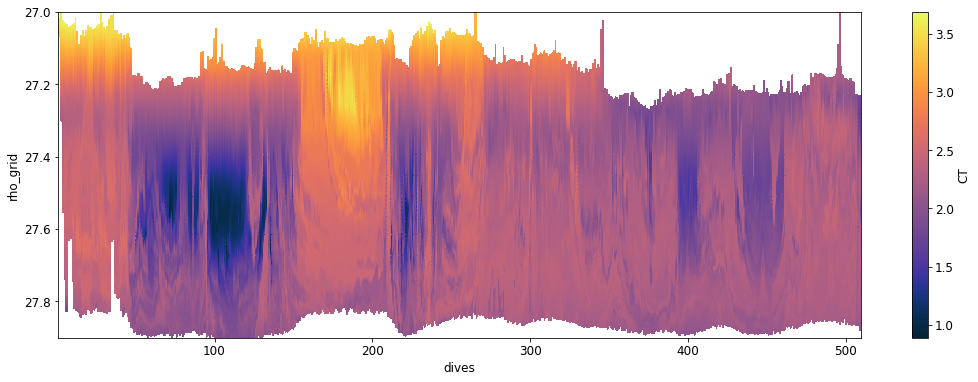

In [162]:
plt.figure(figsize=(18,6))
ds_660_tilde.CT.plot(cmap=cmo.thermal)
plt.gca().invert_yaxis()

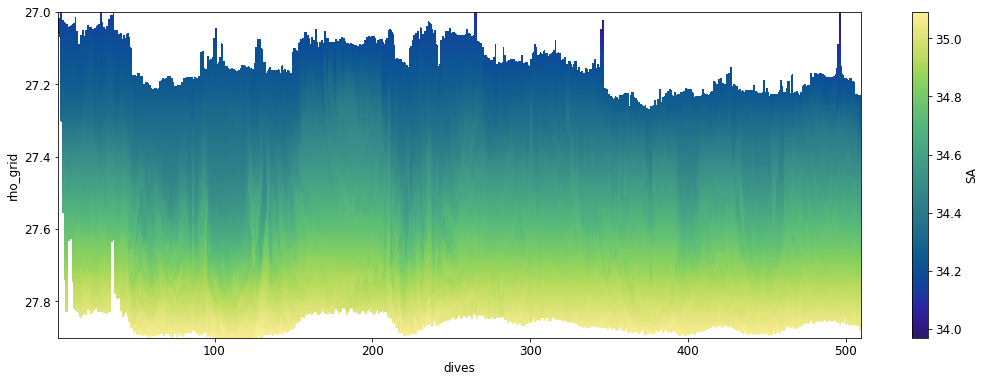

In [167]:
plt.figure(figsize=(18,6))
ds_660_tilde.SA.plot(cmap=cmo.haline)
plt.gca().invert_yaxis()

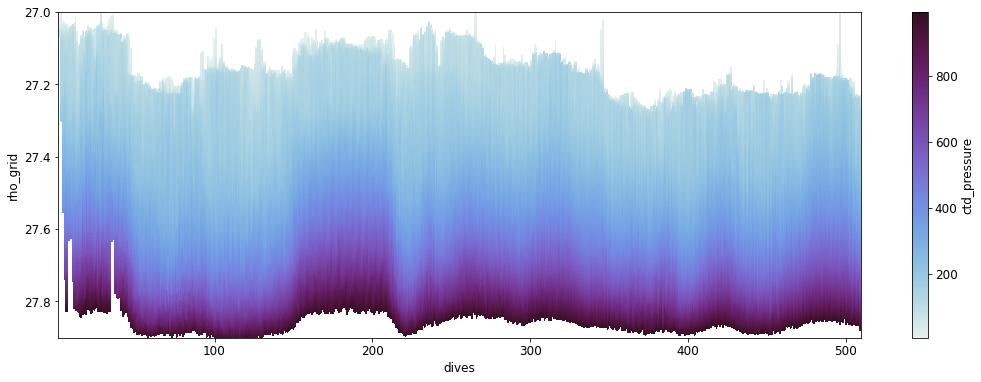

In [168]:
plt.figure(figsize=(18,6))
ds_660_tilde.ctd_pressure.plot(cmap=cmo.dense)
plt.gca().invert_yaxis()

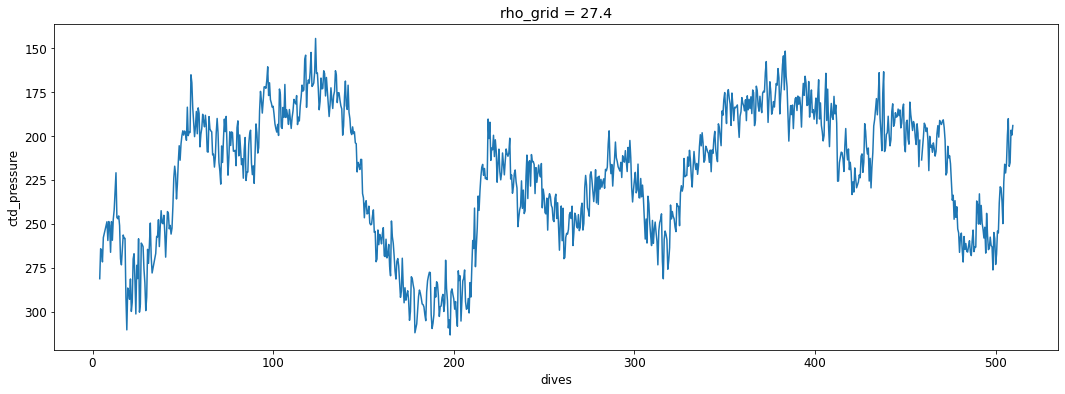

In [169]:
plt.figure(figsize=(18,6))
ds_660_tilde.ctd_pressure.sel(rho_grid=27.4, method='nearest').plot()
plt.gca().invert_yaxis()

In [170]:
ds_660_tilde.to_netcdf('data/ctd_660_isopycnal_grid_14_july_2021.nc')